In [1]:
# External packages
import pickle
import sys
import time
import matplotlib.pyplot as plt 
import numpy as np
import pickle
from os import path 
sys.path.append(r"../tools/") 

# Internal packages
from system import modelinput
from system import tanksystem
from system import sensors 
from autocalibration import autocal 
from filters import HighPassFilter
from control import PIcontroller

# Get simulated measurement error

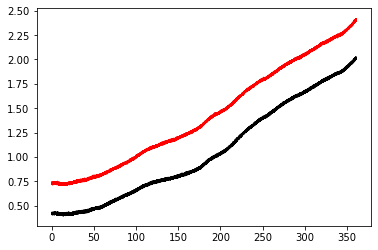

In [2]:
filename = './result/result_step1_measurement_error.pckl'
infile = open(filename,'rb')
[t_,measurement_error,offset,noise] = pickle.load(infile)
infile.close()

plt.plot(t_ ,measurement_error[0,:],'k-') 
plt.plot(t_ ,measurement_error[1,:],'r--') ;

# System parameters

In [3]:
Nmax = 4*24*360+1 #len(t_)-1
timespan = t_[Nmax-1]
a0 = 4.0/2
a = np.array([.2,.2,1])/2
theta = np.array([0.5,1.0,360.0])
phi = np.array([0*1/2,1/16*1,1/4*360])
np.random.seed(11)
Uk = np.random.rand(int(timespan)+1)
knot = np.arange(0,timespan+1,theta[1])

sys_tau = 1/25
sys_kappa = 4

# Tuning parameters

In [4]:
# Auto-calibration tool
calibration_window = 96  # length as # samples
beta_hat_init       = np.zeros(2) # Initial offset estimates
calibration_interval = 24 # hours between consecutive sensor calibrations
#W = 96 

# high-pass filter
alpha_HP            = 0.2

# dither
amp_perturb_orig         = 0.25
freq_perturbation   = 6

# computation of psi
epsilon = 1e-12

# PID for psi 
if True:
    K_psi               = 0
    I_psi               = -0.1 
    psi_setpoint        = 0.5
    y_limit             = [0,10]
    y0_setpoint_default = 3.0
    pass
changepointsearch_interval = 15 # days between activation changepoint-seeking control

# PID for tank level
K_y                 = .5
I_y                 = 0.1
#y0_setpoint         = y0_setpoint_default
u_limit             = [0,1]
u_init              = 0.23
if True:
    
    K_y0                   = .5
    I_y0                   = 0.1
    u_limit             = [0,1]
    u_init              = 0.23
    pass


In [5]:

ts = np.array([])
#colours = ['r','b','g']

#calibration_interval = 15
Ly = 2
for scenario in range(0,2): 
    
    print('\n Scenario '+chr(ord('A')+scenario) )
    amp_perturb = amp_perturb_orig*1
    noise_ON    = 1
    delta = np.array([0,5]) 
    
    if scenario==0: 
        time_dither_ON = 1
        time_dither_OFF = 5
        time_changepointseeking_ON = 2
        time_changepointseeking_OFF = 4
        autocalibration_ON = False
        
        N = 4*24*6+1 
        pass
    elif scenario==1:  
        time_dither_ON = 1
        time_dither_OFF = 5
        time_changepointseeking_ON = 2
        time_changepointseeking_OFF = 4
        autocalibration_ON = True
        N = 4*24*6+1 
        pass
    elif scenario==2:  
        time_dither_ON = 14
        time_dither_OFF = 15
        time_changepointseeking_ON = 14
        time_changepointseeking_OFF = 15
        autocalibration_ON = True
        N = 4*24*360+1 
        pass
    elif scenario==3:  
        time_dither_ON = 14
        time_dither_OFF = 15
        time_changepointseeking_ON = 14
        time_changepointseeking_OFF = 15
        autocalibration_ON = False
        calibration_interval=1
        N = 4*24*360+1 
        pass
    flow                = modelinput(a0,a,phi,theta,knot,Uk)
    
    k                   = 0
    
    # ===============================
    # SETUP OBJECTS
    # ===============================
    
    # SYSTEM
    x0                  = np.array(0)+3-measurement_error[0,k]
    t0_sim              = t_[0]
    qfun                = lambda t: flow.simulate(t)
    system              = tanksystem(sys_kappa,sys_tau,qfun,x0)
    sens                = sensors(delta) 
    
    # PID for psi 
    y0_setpoint_ref     = y0_setpoint_default
    PImaster            = PIcontroller(K=K_psi,
                                       I=I_psi,
                                       u_limit=y_limit,
                                       u=y0_setpoint_default,
                                       y_setpoint=psi_setpoint)
    
    # PID for tank level
    PIslave             = PIcontroller(K=K_y0,
                                       I=I_y0,
                                       u_limit=u_limit,
                                       u=u_init,
                                       y_setpoint=y0_setpoint_default)
     
    # AUTO-CALIBRATION
    beta_hat_init       = np.zeros(2)
    window              = 96 
    sensorcalibration   = autocal(delta,beta_hat_init,window)
    ts                  = t_[0]  
    
    # ===============================
    # EVALUATE k=0
    # ===============================
    
    # Collect initial measurement: 
    y                   = sens.simulate(x0) +measurement_error[:,k]
    y_adjusted          = y-beta_hat_init 
    y_adjusted_previous = y_adjusted
    
    # Collect initial control action:
    u                   = PIslave.compute_control_action(y_adjusted[0]) 
    
    # Set up and initialize high-pass filter:
    HP                  = HighPassFilter(alpha_HP,y_adjusted)
    y_hp                = HP.update(y_adjusted) 
    
    # Correlation measure
    outer               = np.matmul(y_hp[:,None],y_hp[:,None].T) 
    b1                  = outer[0,0]*outer[0,1]
    b2                  = outer[1,1]*outer[0,1]
    psi                 = 1-np.abs( (b1-b2+epsilon)/(b1+b2+epsilon) ) 
    
    # ==============================================================
    # INITIALIZE ARRAYS CONTAINING SIMULATED TRAJECTORIES
    # ==============================================================
    
    trajectory_x           = x0[None,None]
    trajectory_y           = y[None,:]
    trajectory_y_adjusted  = y_adjusted[None,:] 
    trajectory_beta_hat    = beta_hat_init[:,None]
    trajectory_y0_setpoint = np.array(y0_setpoint_default)
    trajectory_u           = np.array(u_init)
    trajectory_psi_tilde   = np.array([psi])  
    trajectory_y_hp        = y_hp[None,:]
    
    t_dither = 0
    
    # ==============================================================
    # ACTUAL SIMULATION
    # ==============================================================
    for k in range(1,N): 
        
        
        t1_sim = t_[k] 
        timestep = t1_sim-t0_sim
        t0_sim = t1_sim
        
        if np.mod(t1_sim,0.25)==0:
            sys.stdout.write("\r{0}>".format("" * 1) + " Simulated time: "  + str('{0:.2f}'.format(t1_sim)) + " days")
            sys.stdout.flush()
            pass
        
        # =======================================================
        # PHYSICAL SYSTEM SIMULATION
        x = system.simulate(timestep,u) 
        y = sens.simulate(x) +measurement_error[:,k]
        
        # =======================================================
        # AUTO-CALIBRATION AND MEASUREMENT ADJUSTMENT
        sensorcalibration.add_data(y)
        
        if autocalibration_ON and (np.mod(k,calibration_interval)==0 and k>=calibration_window): 
            ts = np.append(ts,t_[k])
            
            sensorcalibration.calibrate()
            beta_hat = sensorcalibration.theta
            trajectory_beta_hat = np.hstack([trajectory_beta_hat,beta_hat[:,None]])
            
            pass
        
        y_adjusted = y-sensorcalibration.theta 
        
        # =======================================================
        # HP filter
        HP.apply_input_correction(sensorcalibration.theta_diff) # Ensures bumpless tranfer 
        y_hp = HP.update(y_adjusted) 
        
        # =======================================================
        # MEASUREMENT OF PSI
        outer = np.matmul(y_hp[:,None],y_hp[:,None].T) 
        b1  = outer[0,0]*outer[0,1]
        b2  = outer[1,1]*outer[0,1]
        psi_tilde = 1-(np.abs(b1-b2)+epsilon)/(np.abs(b1+b2)+epsilon) 
        
        # =======================================================
        # MASTER CONTROL
        BOOL_MASTER_1 = np.mod(t_[k] ,changepointsearch_interval)>=time_changepointseeking_ON
        BOOL_MASTER_2 = np.mod(t_[k] ,changepointsearch_interval)<time_changepointseeking_OFF
        MASTER_CONTROL_ON = BOOL_MASTER_1 and BOOL_MASTER_2
        if MASTER_CONTROL_ON:
            PImaster.update_setpoint(psi_setpoint)
            y0_setpoint_ref = PImaster.compute_control_action(psi_tilde)  
            pass
        else:
            # When master controller is "off", repurpose it to adjust slave controller setpoint gradually to 
            # desired user-set setpoint. This avoids drastic changes in slave controller setpoint.
            PImaster.update_setpoint(y0_setpoint_default)
            y0_setpoint_ref = PImaster.compute_control_action(y0_setpoint_ref)  
            pass
        y0_setpoint_ref = PImaster.apply_output_correction(sensorcalibration.theta_diff[0]) 
        
        # =======================================================
        # DITHER SIGNAL
        BOOL_DITHER_1 = np.mod(t_[k], changepointsearch_interval)>=time_dither_ON
        BOOL_DITHER_2 = np.mod(t_[k], changepointsearch_interval)<time_dither_OFF
        DITHER_ON = BOOL_DITHER_1 and BOOL_DITHER_2
        if DITHER_ON:
            dither = np.sin((t_[k] -t_dither)*freq_perturbation*2*np.pi) 
            pass
        else:
            dither = 0
            t_dither = t_[k] 
            pass
        
        y0_setpoint = y0_setpoint_ref+amp_perturb*dither
        
        # =======================================================
        # SLAVE CONTROL
        PIslave.update_setpoint(y0_setpoint) # Ensures bumpless tranfer
        PIslave.apply_input_correction(sensorcalibration.theta_diff[0]) # Ensures bumpless tranfer 
        u = PIslave.compute_control_action(y_adjusted[0])  
        
        # =======================================================
        # ADD DATA TO TRAJECTORIES
        trajectory_x = np.append(trajectory_x,x[None,None],axis=0)
        trajectory_y = np.append(trajectory_y,y[None,:],axis=0)
        trajectory_y_adjusted = np.append(trajectory_y_adjusted,y_adjusted[None,:],axis=0) 
        trajectory_y_hp = np.append(trajectory_y_hp,y_hp[None,:],axis=0) 
        trajectory_u = np.append(trajectory_u,u) 
        trajectory_y0_setpoint = np.append(trajectory_y0_setpoint,y0_setpoint)
        trajectory_psi_tilde = np.append(trajectory_psi_tilde,psi_tilde) 
        
        pass
    
    # ==============================================================
    # SAVE RESULTS
    # ==============================================================
    
    results = {'t': t_[:N],
               'x': trajectory_x,
               'y': trajectory_y,
               'y_adjusted': trajectory_y_adjusted,
               'y_hp': trajectory_y_hp,
               'u': trajectory_u,
               'y0_setpoint': trajectory_y0_setpoint,
               'psi_tilde': trajectory_psi_tilde,
               't_cal': ts,
               'beta': trajectory_beta_hat,
               'delta':delta,
               'PImaster':PImaster,
               'PIslave':PIslave}  
    
    filename = 'results_scenario_'+chr(ord('A')+scenario)+'.pckl'
    outfile = open(filename,'wb')
    pickle.dump(results,outfile)
    outfile.close()
    
    pass


 Scenario A
> Simulated time: 6.00 days
 Scenario B
> Simulated time: 6.00 days


 Scenario A

 Discontinuity crossed for the first time at: 2.667d .

 Scenario B

 Discontinuity crossed for the first time at: 2.667d .


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

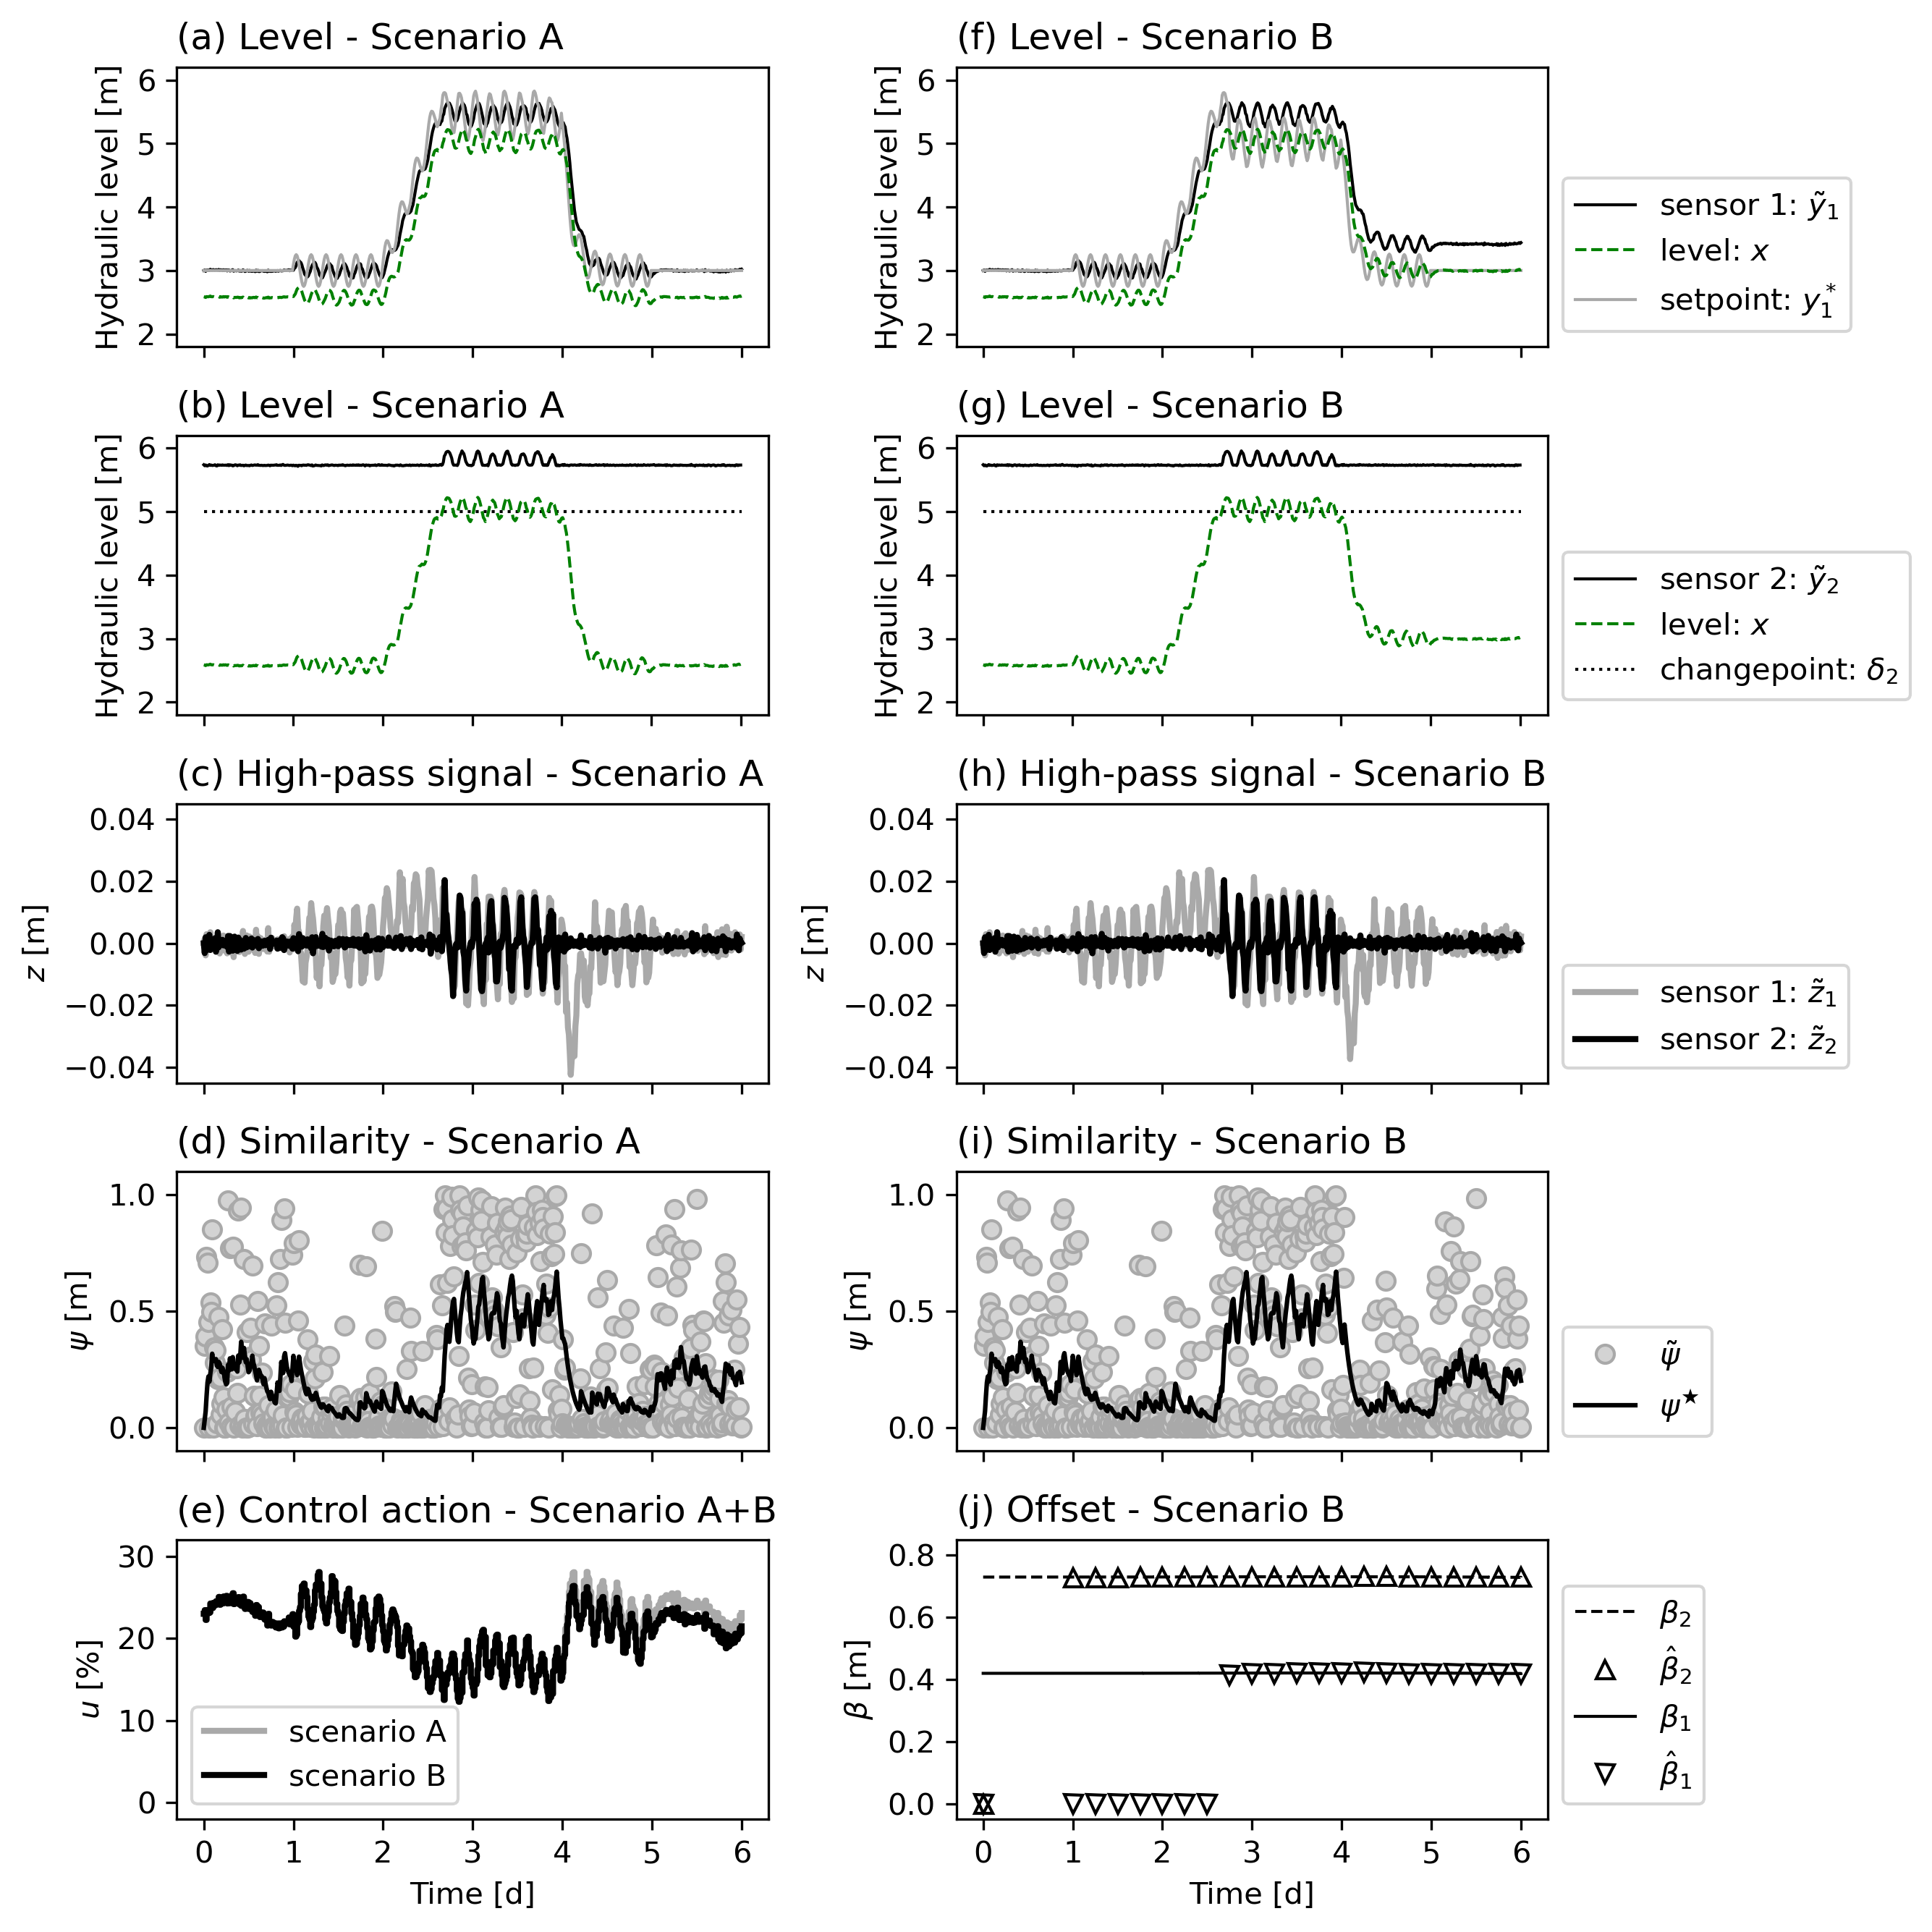

In [6]:
# Figure 1 - Scenario A and B
fig, axs = plt.subplots(5,2,figsize=(9,9),dpi=300)
panelnumber = 0
        
for scenario in range(0,2):
    
    print('\n Scenario '+chr(ord('A')+scenario) )
    
    filename = 'results_scenario_'+chr(ord('A')+scenario)+'.pckl'
    infile = open(filename,'rb')
    results = pickle.load(infile)
    
    trajectory_x = results['x']
    trajectory_y = results['y']
    trajectory_y_adjusted = results['y_adjusted']
    trajectory_y_hp = results['y_hp']
    trajectory_u = results['u']
    trajectory_y0_setpoint = results['y0_setpoint']
    trajectory_psi_tilde =  results['psi_tilde']
    ts = results['t_cal']
    trajectory_beta_hat =  results['beta']
    N = len(trajectory_x)
    
    t_cross = t_[np.where(trajectory_x>delta[1])[0][0]]
    if True:
        print('\n Discontinuity crossed for the first time at: '+str(np.round(t_cross,3))+'d .')

        ax = axs[0,scenario]   
        ax.plot(t_[:N],trajectory_y[:,0],'k-',lw=1,label=r'sensor 1: $\tilde{y}_1$',zorder=0) 
        ax.plot(t_[:N],trajectory_x[:,0],'g--',lw=1,label=r'level: $x$',zorder=2) 
        ax.plot(t_[:N],trajectory_y0_setpoint,'-',color='darkgrey',lw=1,label=r'setpoint: $y^*_1$',zorder=1)  
        ax.set_ylim([1.8,+6.2]) 
        ax.set_yticks(np.arange(2,6.1,1))
        ax.set_xticks(np.arange(0,7))
        ax.set_ylabel(r'$x$, $y_1$ [m]')
        ax.set_ylabel('Hydraulic level [m]')
        ax.set_xticklabels(labels=[])
        if scenario==1:
            ax.legend(loc='lower left', bbox_to_anchor=(1, 0))
            pass
        ax.set_title('('+ chr(ord('a')+panelnumber)+') Level - Scenario '+chr(ord('A')+scenario), loc='left')
        panelnumber +=1 
        
        ax = axs[1,scenario]  
        ax.plot(t_[:N],trajectory_y[:,1],'k-',lw=1,label=r'sensor 2: $\tilde{y}_2$',zorder=0) 
        ax.plot(t_[:N],trajectory_x[:,0],'g--',lw=1,label=r'level: $x$',zorder=2)   
        ax.hlines(y=5,xmin=0,xmax=t_[N],color='black',lw=1,linestyle=':',label=r'changepoint: $\delta_2$',zorder=1)
        ax.set_ylim([1.8,+6.2])
        ax.set_yticks(np.arange(2,6.1,1))
        ax.set_xticks(np.arange(0,7))
        ax.set_ylabel('Hydraulic level [m]')
        ax.set_xticklabels(labels=[])
        if scenario==1:
            ax.legend(loc='lower left', bbox_to_anchor=(1, 0)) 
            pass
        ax.set_title('('+ chr(ord('a')+panelnumber)+') Level - Scenario '+chr(ord('A')+scenario), loc='left')
        panelnumber +=1 
        
        ax = axs[2,scenario] 
        ax.plot(t_[:N],trajectory_y_hp[:,0],'-',color='darkgrey' ,lw=2,label=r'sensor 1: $\tilde{z}_1$') 
        ax.plot(t_[:N],trajectory_y_hp[:,1],'k-',lw=2,label=r'sensor 2: $\tilde{z}_2$')   
        ax.set_ylim([-0.045,+0.045])
        ax.set_yticks(np.arange(-0.04,+0.041,0.02))
        ax.set_xticks(np.arange(0,7))
        ax.set_ylabel(r'$z$ [m]')
        ax.set_xticklabels(labels=[])
        if scenario==1:
            ax.legend(loc='lower left', bbox_to_anchor=(1, 0)) 
            pass
        ax.set_title('('+ chr(ord('a')+panelnumber)+') High-pass signal - Scenario '+chr(ord('A')+scenario), loc='left')
        panelnumber +=1 
        
        ax = axs[3,scenario]   
        ax.step(t_[:N],trajectory_psi_tilde,'o',mfc='lightgrey',color='darkgrey',lw=2,where='post',label=r'$\tilde{\psi}$')   
        trajectory_psi_filt = trajectory_psi_tilde
        for k in range(1,N):
            trajectory_psi_filt[k] = (1+PImaster.I)*trajectory_psi_filt[k-1]-PImaster.I*(trajectory_psi_tilde[k])
            pass
        ax.plot(t_[:N],trajectory_psi_filt ,'k-',label=r'$\psi^{\bigstar}$' )  
        ax.set_ylim([-.1,+1.1])
        ax.set_xticks(np.arange(0,7))
        ax.set_ylabel(r'$\psi$ [m]')
        ax.set_xticklabels(labels=[])
        if scenario==1:
            ax.legend(loc='lower left', bbox_to_anchor=(1, 0))
            pass
        ax.set_title('('+ chr(ord('a')+panelnumber)+') Similarity - Scenario '+chr(ord('A')+scenario), loc='left')
        panelnumber +=1 
        
        ax = axs[4,0]  
        if scenario==0:
            ax.step(t_[:N],trajectory_u*100,'-',color='darkgrey',lw=2,where='post',label=r'scenario A') 
            ax.set_title('('+ chr(ord('a')+panelnumber)+') Control action - Scenario A+B', loc='left') 
            panelnumber +=1  
            pass
        else:
            ax.step(t_[:N],trajectory_u*100,'k-',lw=2,where='post',label=r'scenario B')   
            ax.legend(loc='lower left')
            ax.autoscale()
            ax.set_ylim([-2,32])
            ax.set_xticks(np.arange(0,7))
            ax.set_xlabel('Time [d]')
            ax.set_ylabel(r'$u$ [%]')
            pass
        
        ax = axs[4,1]  
        if scenario==0:
            pass
        else:
            ax.step(t_[:N],offset[1,:N].T,'--',color='black',lw=1,where='post',label=r'$\beta_2$') 
            ax.step(ts,trajectory_beta_hat[1,:].T,'^',color='black',mfc='None',lw=2,where='post',label=r'$\hat{\beta}_2$') 
            ax.step(t_[:N],offset[0,:N].T,'-',color='black',lw=1,where='post',label=r'$\beta_1$')   
            ax.step(ts,trajectory_beta_hat[0,:].T,'v',color='black',mfc='None',lw=2,where='post',label=r'$\hat{\beta}_1$')   
            ax.legend(loc='lower left', bbox_to_anchor=(1, 0))
            ax.autoscale()
            ax.set_ylim([-.05,+.85])  
            ax.set_yticks(np.arange(-0,+0.81,0.2))
            ax.set_xticks(np.arange(0,7))
            ax.set_xlabel('Time [d]')
            ax.set_ylabel(r'$\beta$ [m]')
            ax.set_title('('+ chr(ord('a')+panelnumber)+') Offset - Scenario '+chr(ord('A')+scenario), loc='left')
            panelnumber +=1
            pass
                         
        plt.tight_layout()
        
    pass

fig.savefig('./figure/results_scenario_A_and_B.eps',bbox_inches='tight');
fig.savefig('./figure/results_scenario_A_and_B.tiff',bbox_inches='tight');

In [7]:
# Figure 2 - Scenario B


 Scenario C
Max. error - sensor 1: 0.1369284209169237  - sensor 2: 0.0241531024813888
Mean absolute measurement error 1: 0.08046093455976028
Median absolute measurement error 1: 0.027750629898629864
Mean absolute measurement error 2: 0.038352107944114124
Median absolute measurement error 2: 0.004064558828338782
Mean absolute control error: 0.41027328380501166
Median absolute control error: 0.03267144592869853


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



 Scenario D
Max. error - sensor 1: 2.0139661204897665  - sensor 2: 2.4055358451650797
Mean absolute measurement error 1: 0.4954539827350234
Median absolute measurement error 1: 0.9192543688190651
Mean absolute measurement error 2: 0.5171287084548732
Median absolute measurement error 2: 1.3381246817455583
Mean absolute control error: 0.5118897840559469
Median absolute control error: 0.9112490531768418


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


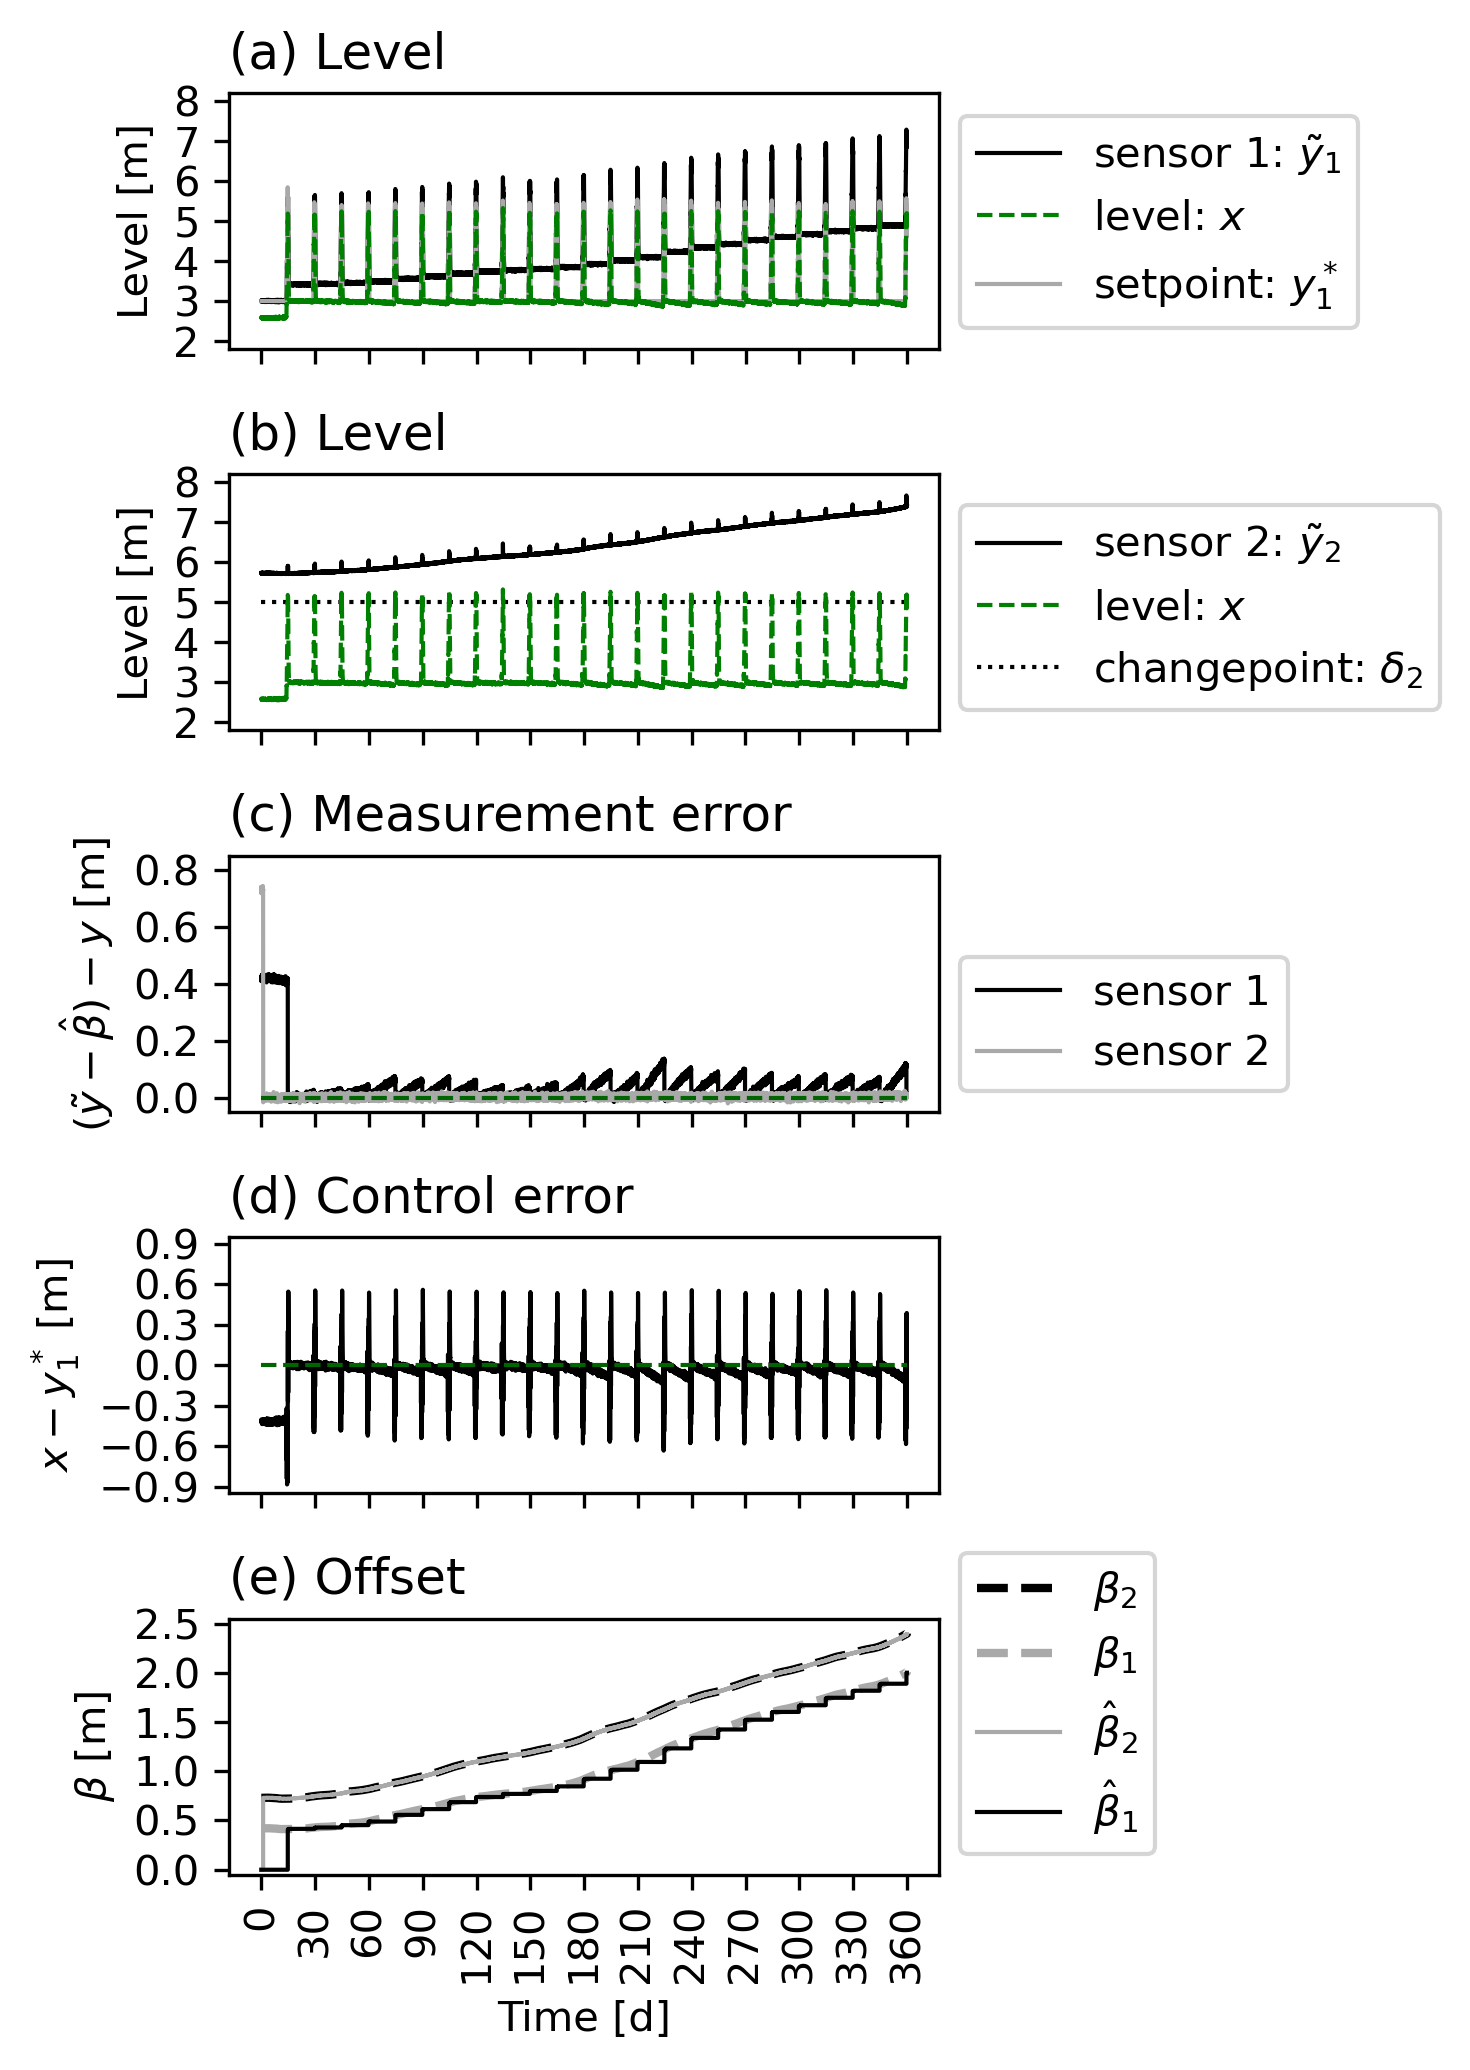

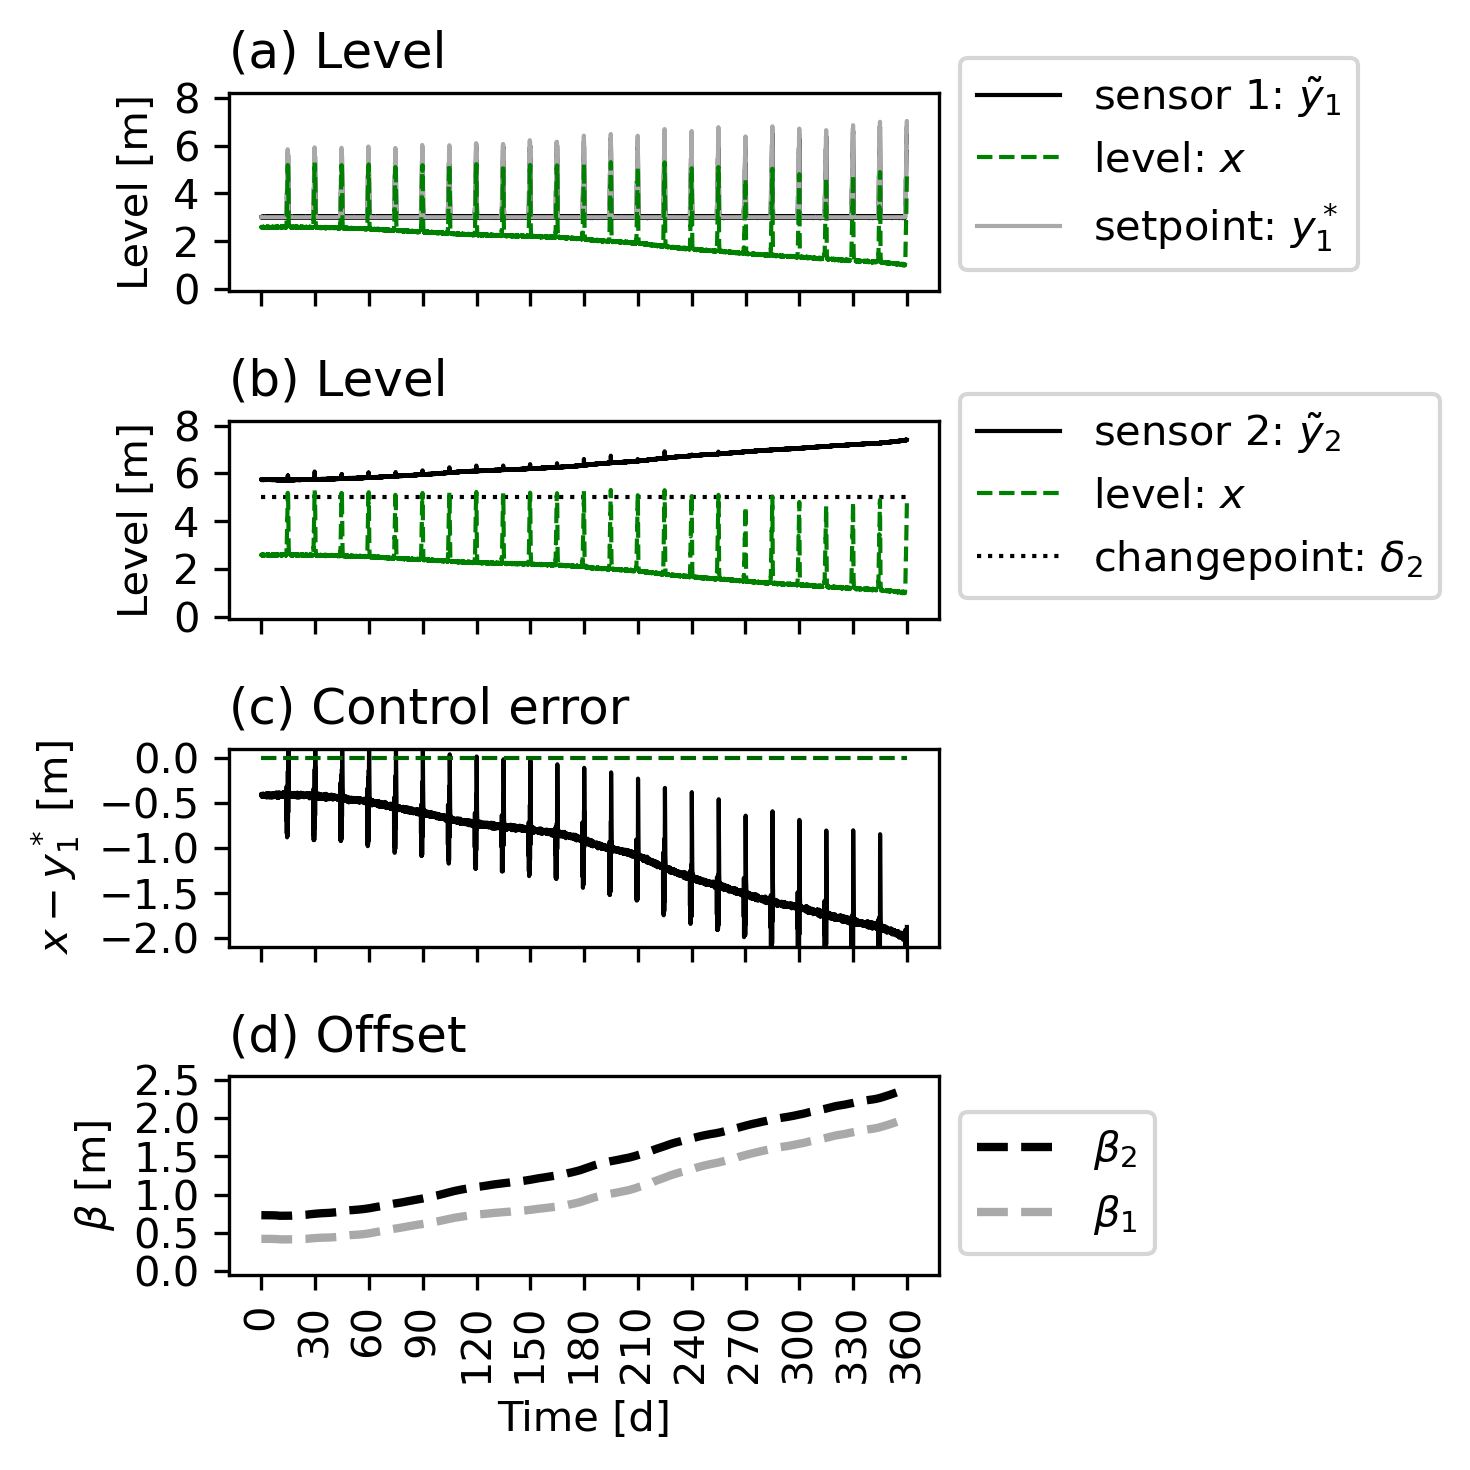

In [8]:
# Figure 3 and 4 - Scenario C and D 
for scenario in range(2,4):
    
    print('\n Scenario '+chr(ord('A')+scenario) )
    
    filename = 'results_scenario_'+chr(ord('A')+scenario)+'.pckl'
    infile = open(filename,'rb')
    results = pickle.load(infile)
    
    trajectory_x = results['x']
    trajectory_y = results['y']
    trajectory_y_adjusted = results['y_adjusted']
    trajectory_y_hp = results['y_hp']
    trajectory_u = results['u']
    trajectory_y0_setpoint = results['y0_setpoint']
    #trajectory_psi =  results['psi_tilde']
    ts = results['t_cal']
    trajectory_beta_hat =  results['beta']
    N = len(trajectory_x)
    
    ysim = sens.simulate(trajectory_x.flatten()[:,None])
    error0 = trajectory_y_adjusted[:,0]-ysim[:,0]
    error1 = trajectory_y_adjusted[:,1]-ysim[:,1]
    k1 = np.where(t_>15)[0][0]
    arg_max0 = np.argmax(np.abs(error0[k1:]))
    arg_max1 = np.argmax(np.abs(error1[k1:]))
    print('Max. error - sensor 1: '+str(np.abs(error0[k1:])[arg_max0])+ '  - sensor 2: '+str(np.abs(error1[k1:])[arg_max1]))
        
    print('Mean absolute measurement error 1: '+str(np.std((error0))) ) 
    print('Median absolute measurement error 1: '+str(np.median((error0))) )
    print('Mean absolute measurement error 2: '+str(np.std(np.abs(error1))) ) 
    print('Median absolute measurement error 2: '+str(np.median(np.abs(error1))) )
    
    control_error = trajectory_x[:,0]-trajectory_y0_setpoint    
    print('Mean absolute control error: '+str(np.std(np.abs(trajectory_x[:,0]-3))) ) 
    print('Median absolute control error: '+str(np.median(np.abs(trajectory_x[:,0]-3))) )
    
            
    if scenario==2:
        fig, axs = plt.subplots(5,1,figsize=(5,7),dpi=300)
        pass
    else:
        fig, axs = plt.subplots(4,1,figsize=(5,5),dpi=300)
        pass
    if True:
        panelnumber = 0
        xtickstep = 30 
        ax = axs[0] 
        ax.plot(t_[:N],trajectory_y[:,0],'k-',lw=1,label=r'sensor 1: $\tilde{y}_1$',zorder=0) 
        ax.plot(t_[:N],trajectory_x[:,0],'g--',lw=1,label=r'level: $x$',zorder=2) 
        ax.plot(t_[:N],trajectory_y0_setpoint,'-',color='darkgrey',lw=1,label=r'setpoint: $y^*_1$',zorder=1)  
        ax.set_xticks(np.arange(0,t_[N],xtickstep))  
        if scenario==2:
            ax.set_ylim([1.8,+8.2]) 
            ax.set_yticks(np.arange(2,8.1,1))
            pass
        else:
            ax.set_ylim([-0.1,+8.2]) 
            ax.set_yticks(np.arange(0,8.1,2))
            pass
        ax.set_ylabel('Level [m]')
        ax.legend(loc='lower left', bbox_to_anchor=(1, 0))
        ax.set_title('('+ chr(ord('a')+panelnumber)+') Level', loc='left')
        plt.setp(ax.get_xticklabels(), rotation=90, va='center', ha="right", rotation_mode="anchor")
        ax.set_xticklabels(labels=[])
        panelnumber +=1 
        
        ax = axs[1]  
        ax.plot(t_[:N],trajectory_y[:,1],'k-',lw=1,label=r'sensor 2: $\tilde{y}_2$',zorder=0) 
        ax.plot(t_[:N],trajectory_x[:,0],'g--',lw=1,label=r'level: $x$',zorder=2)   
        ax.hlines(y=5,xmin=0,xmax=t_[N],color='black',lw=1,linestyle=':',label=r'changepoint: $\delta_2$',zorder=1)
        ax.set_xticks(np.arange(0,t_[N],xtickstep))
        if scenario==2:
            ax.set_ylim([1.8,+8.2]) 
            ax.set_yticks(np.arange(2,8.1,1))
            pass
        else:
            ax.set_ylim([-0.1,+8.2]) 
            ax.set_yticks(np.arange(0,8.1,2))
            pass
        ax.set_ylabel('Level [m]')
        ax.legend(loc='lower left', bbox_to_anchor=(1, 0))
        ax.set_title('('+ chr(ord('a')+panelnumber)+') Level', loc='left')
        plt.setp(ax.get_xticklabels(), rotation=90, va='center', ha="right", rotation_mode="anchor")
        ax.set_xticklabels(labels=[])
        panelnumber +=1 
        
        if scenario==2:
            ax = axs[2] 
            ax.plot(t_[:N],error0,'-',color='black',lw=1,label=r'sensor 1',zorder=0)  
            ax.hlines(y=0,xmin=0,xmax=t_[N],color='darkgreen',lw=1,linestyle='--',zorder=2)
            ax.plot(t_[:N],error1,'-',color='darkgrey',lw=1,label=r'sensor 2',zorder=1)  
            ax.set_xticks(np.arange(0,t_[N],xtickstep))
            ax.set_ylim([-0.05,+0.85])
            ax.set_yticks(np.arange(0,0.81,0.2))
            ax.set_ylabel(r'$(\tilde{y}-\hat{\beta})-y$ [m]')
            ax.legend(loc='lower left', bbox_to_anchor=(1, 0))
            ax.set_title('('+ chr(ord('a')+panelnumber)+') Measurement error', loc='left')
            plt.setp(ax.get_xticklabels(), rotation=90, va='center', ha="right", rotation_mode="anchor")
            ax.set_xticklabels(labels=[])
            panelnumber +=1 
            pass
        
        if scenario==2:
            ax = axs[3]   
            pass
        else:
            ax = axs[2] 
            pass
        ax.plot(t_[:N],control_error,'k-',lw=1,label=r'control error',zorder=0) 
        ax.set_xticks(np.arange(0,t_[N],xtickstep))
        if scenario==2:
            ax.set_ylim([-.95,+.95])  
            ax.set_yticks(np.arange(-0.9,+0.91,0.3))
            pass
        else:
            ax.set_ylim([-2.1,+.1])  
            ax.set_yticks(np.arange(-2,+0.1,0.5))
            pass
        ax.hlines(y=0,xmin=0,xmax=t_[N],color='darkgreen',lw=1,linestyle='--',zorder=1)
        ax.set_ylabel(r'$x-y^*_1$ [m]') 
        ax.set_title('('+ chr(ord('a')+panelnumber)+') Control error', loc='left')
        ax.set_xticklabels(labels=[])
        panelnumber +=1 
        
        if scenario==2:
            ax = axs[4]   
            pass
        else:
            ax = axs[3] 
            pass 
        ax.step(t_[:N],offset[1,:N].T,'--',lw=2,color='black',where='post',label=r'$\beta_2$',zorder=0) 
        ax.step(t_[:N],offset[0,:N].T,'--',lw=2,color='darkgrey',where='post',label=r'$\beta_1$',zorder=1)  
              
        if scenario==2:
            ax.step(ts,trajectory_beta_hat[1,:].T,'-',lw=1,color='darkgrey',where='post',label=r'$\hat{\beta}_2$',zorder=2) 
            ax.step(ts,trajectory_beta_hat[0,:].T,'-',lw=1,color='black',where='post',label=r'$\hat{\beta}_1$',zorder=3)   
            pass
        if True:
            ax.legend(loc='lower left', bbox_to_anchor=(1, 0))
            ax.autoscale()
            ax.set_xticks(np.arange(0,t_[N],xtickstep))
            ax.set_ylim([-0.05,+2.55])
            ax.set_yticks(np.arange(0,2.51,0.5)) 
            ax.set_xlabel('Time [d]')
            ax.set_ylabel(r'$\beta$ [m]')
            ax.set_title('('+ chr(ord('a')+panelnumber)+') Offset', loc='left')
            panelnumber +=1
            pass
        plt.setp(ax.get_xticklabels(), rotation=90, va='center', ha="right", rotation_mode="anchor")
        
        plt.tight_layout()
        fig.savefig('./figure/results_scenario_'+chr(ord('A')+scenario)+'.eps',bbox_inches='tight');
        fig.savefig('./figure/results_scenario_'+chr(ord('A')+scenario)+'.tiff',bbox_inches='tight');
        
        pass
    
    pass